

## ARIMA (AutoRegressive Integrated Moving Average)

* Used to understand data and forecast future values
* It works well when data does not depend on external factors 
* Several models (ARIMA, SARIMA, SARIMAX)
* "Integrated" part of the model helps to manage non-stationary data

#### ARIMA(p,d,q)
* AR(p) : Autoregration model that exploits relationship between the current observation and the previous ones over a given period (and a stochastic, not predictable term)
* I(d) : differencing process
* MA(q) : it exploits dependency between the current observation and the residual error from a moving average model apliare to q lagged observations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
ts = pd.read_csv('./data2.csv', header=0, parse_dates=[0], dayfirst=True, index_col=0)
tsr = ts.resample(rule='20T').mean()

<AxesSubplot: xlabel='Time'>

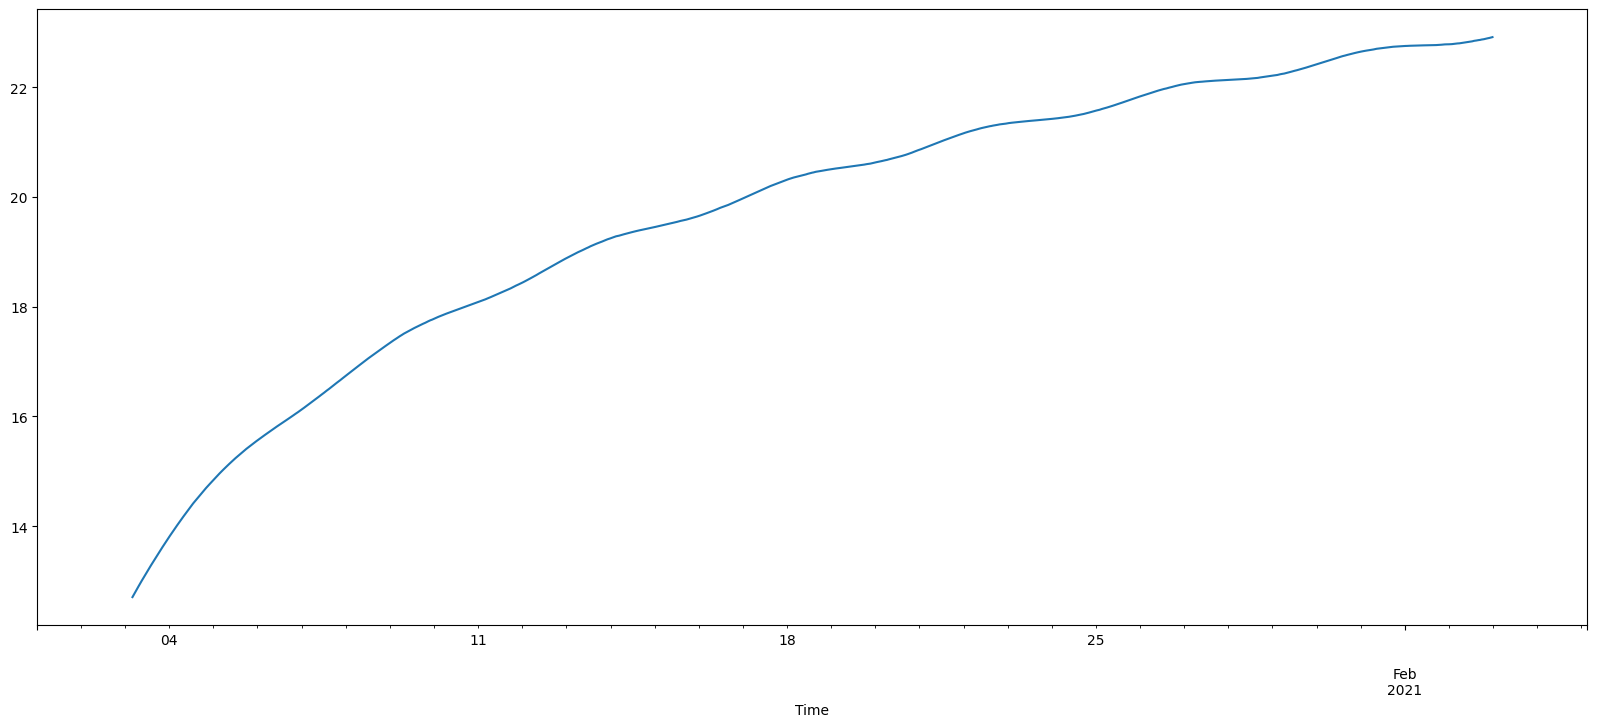

In [2]:
# try to predict trend: Extract TREND
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tsr, model='additive', period=310)  
trend = result.trend
trend.plot(figsize=(20,8))

## AutoRegressive Model (to modify)
In a moving average model as we saw with Holt-Winters, we forecast the variable of interest using a linear combination of predictors. 

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

###### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>

In [3]:
#Work on TREND
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(tsr, model='additive', period=320)  # model='mul' also works
data = result.trend.dropna()

<AxesSubplot: xlabel='Time'>

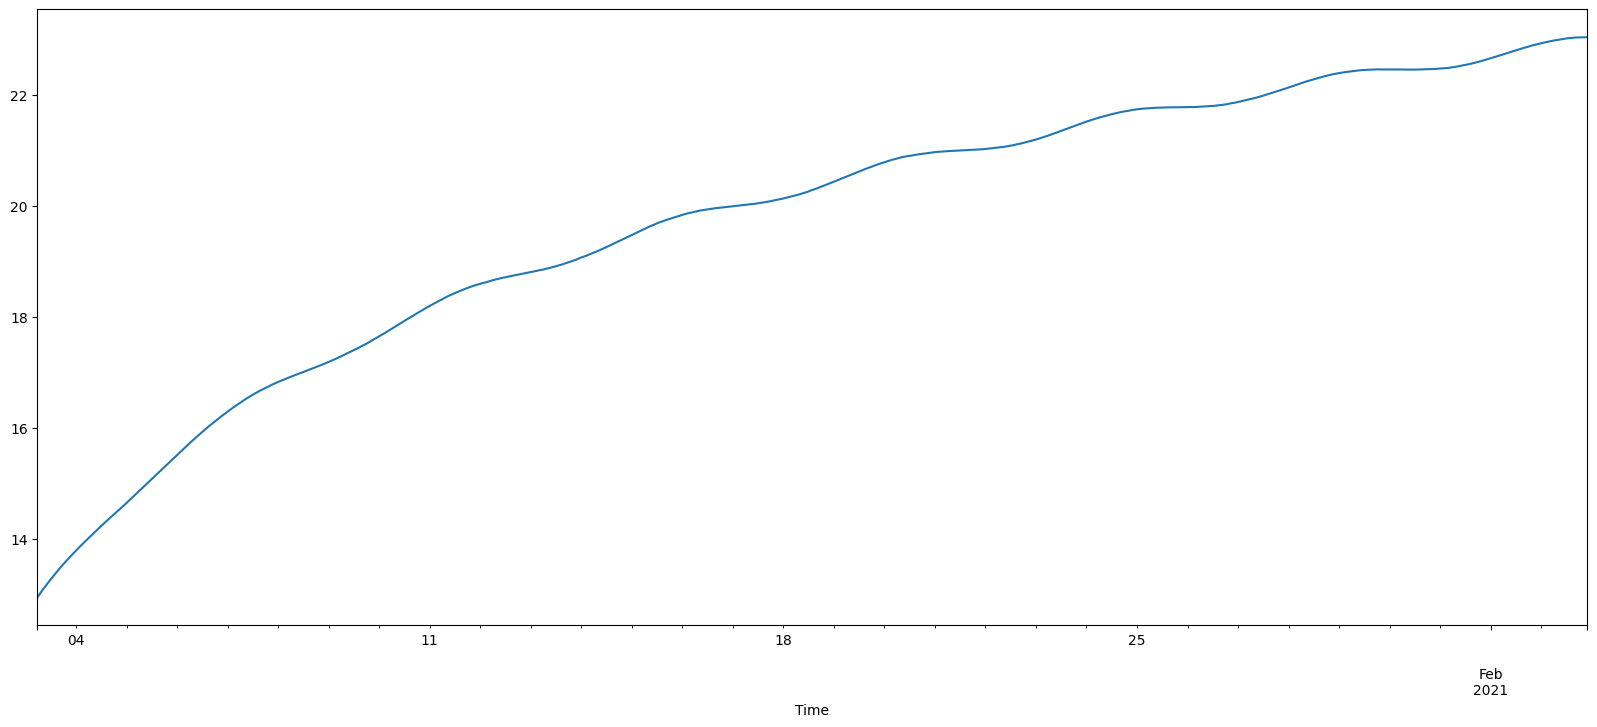

In [4]:
data.plot(figsize=(20,8))

In [5]:
#Split training and test data (90/10)
train_data = data.iloc[:-72]
test_data = data.iloc[-72:]
test_data

Time
2021-02-01 22:20:00    22.917939
2021-02-01 22:40:00    22.921204
2021-02-01 23:00:00    22.924839
2021-02-01 23:20:00    22.928178
2021-02-01 23:40:00    22.930615
                         ...    
2021-02-02 20:40:00    23.039632
2021-02-02 21:00:00    23.040810
2021-02-02 21:20:00    23.041922
2021-02-02 21:40:00    23.042676
2021-02-02 22:00:00    23.042826
Freq: 20T, Name: trend, Length: 72, dtype: float64

In [9]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AutoReg,ARResults
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
#training
model = AutoReg(train_data, lags = 1)
AR1fit = model.fit()  #remove disp=0 to see output

In [14]:
AR1fit.params

const       0.028760
trend.L1    0.998772
dtype: float64

In [15]:
#Prediction
start = len(train_data)
end = start + len(test_data)-1
predictions1 = AR1fit.predict(start=start, end=end)


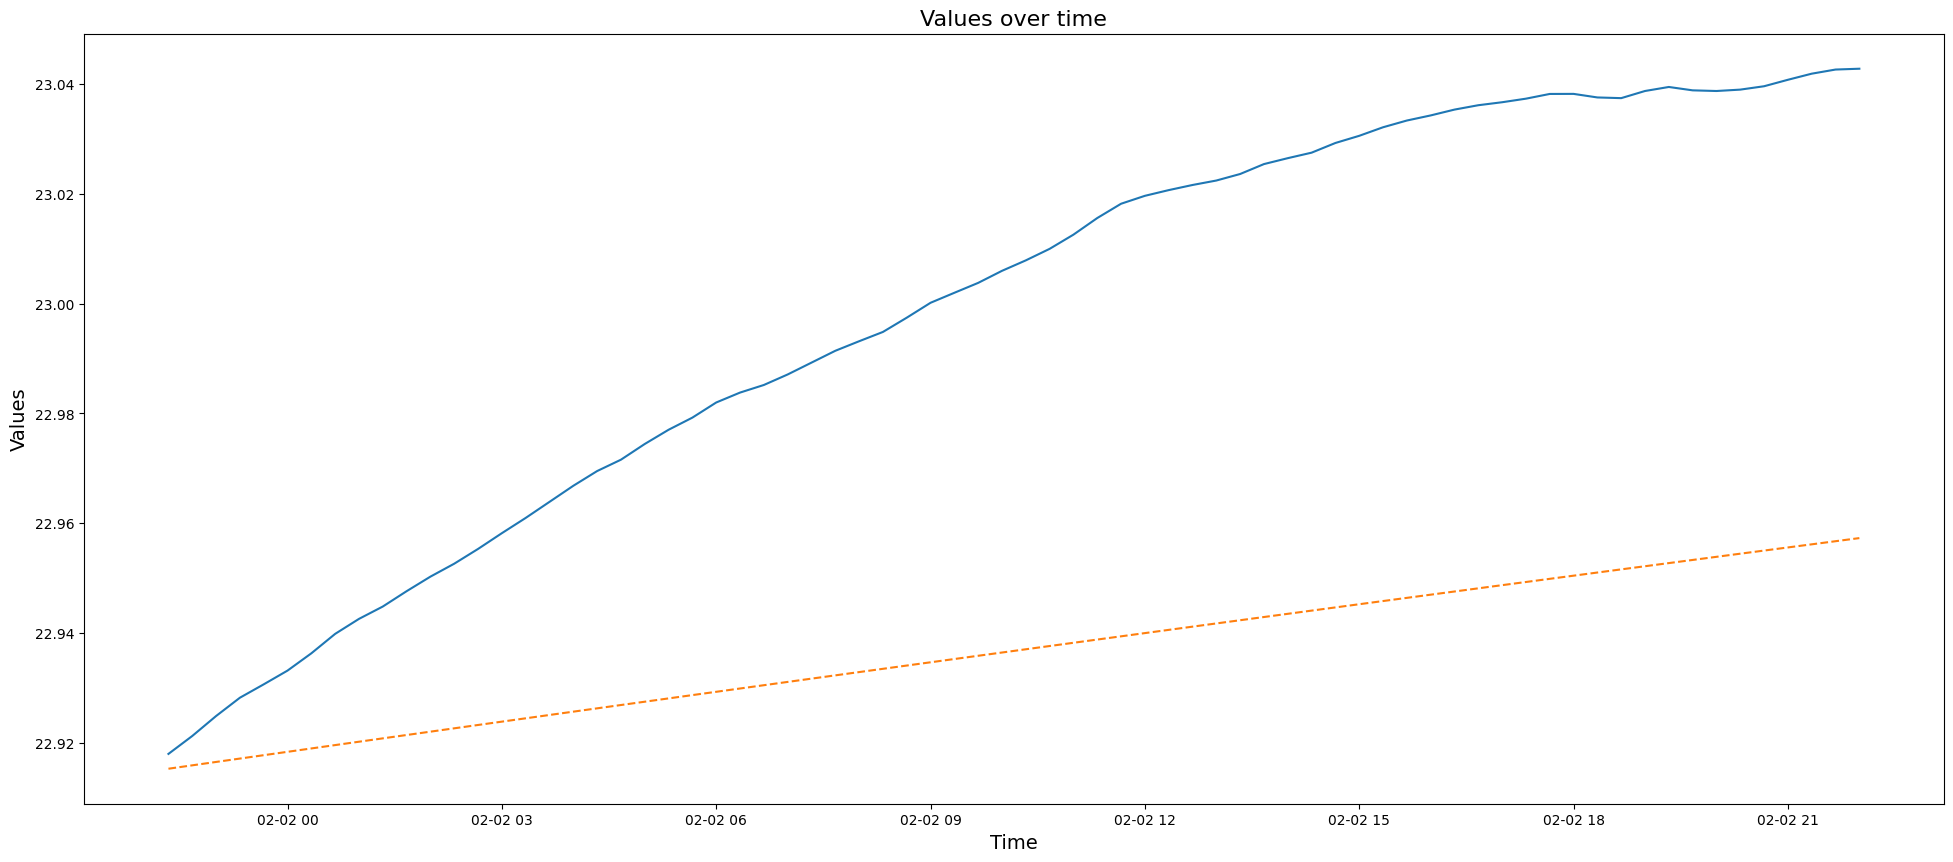

In [16]:
#define size
plt.figure(figsize=(24,10))
#add axes labels and a title
plt.ylabel('Values', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Values over time', fontsize=16)
plt.plot(test_data, "-", label = 'tests')
plt.plot(predictions1,"--", label = 'pred')


In [18]:
#training LET INCREASE THE LAG
model = AutoReg(train_data, lags = 12)
AR12fit = model.fit()

In [19]:
predictions12 = AR12fit.predict(start=start, end=end)

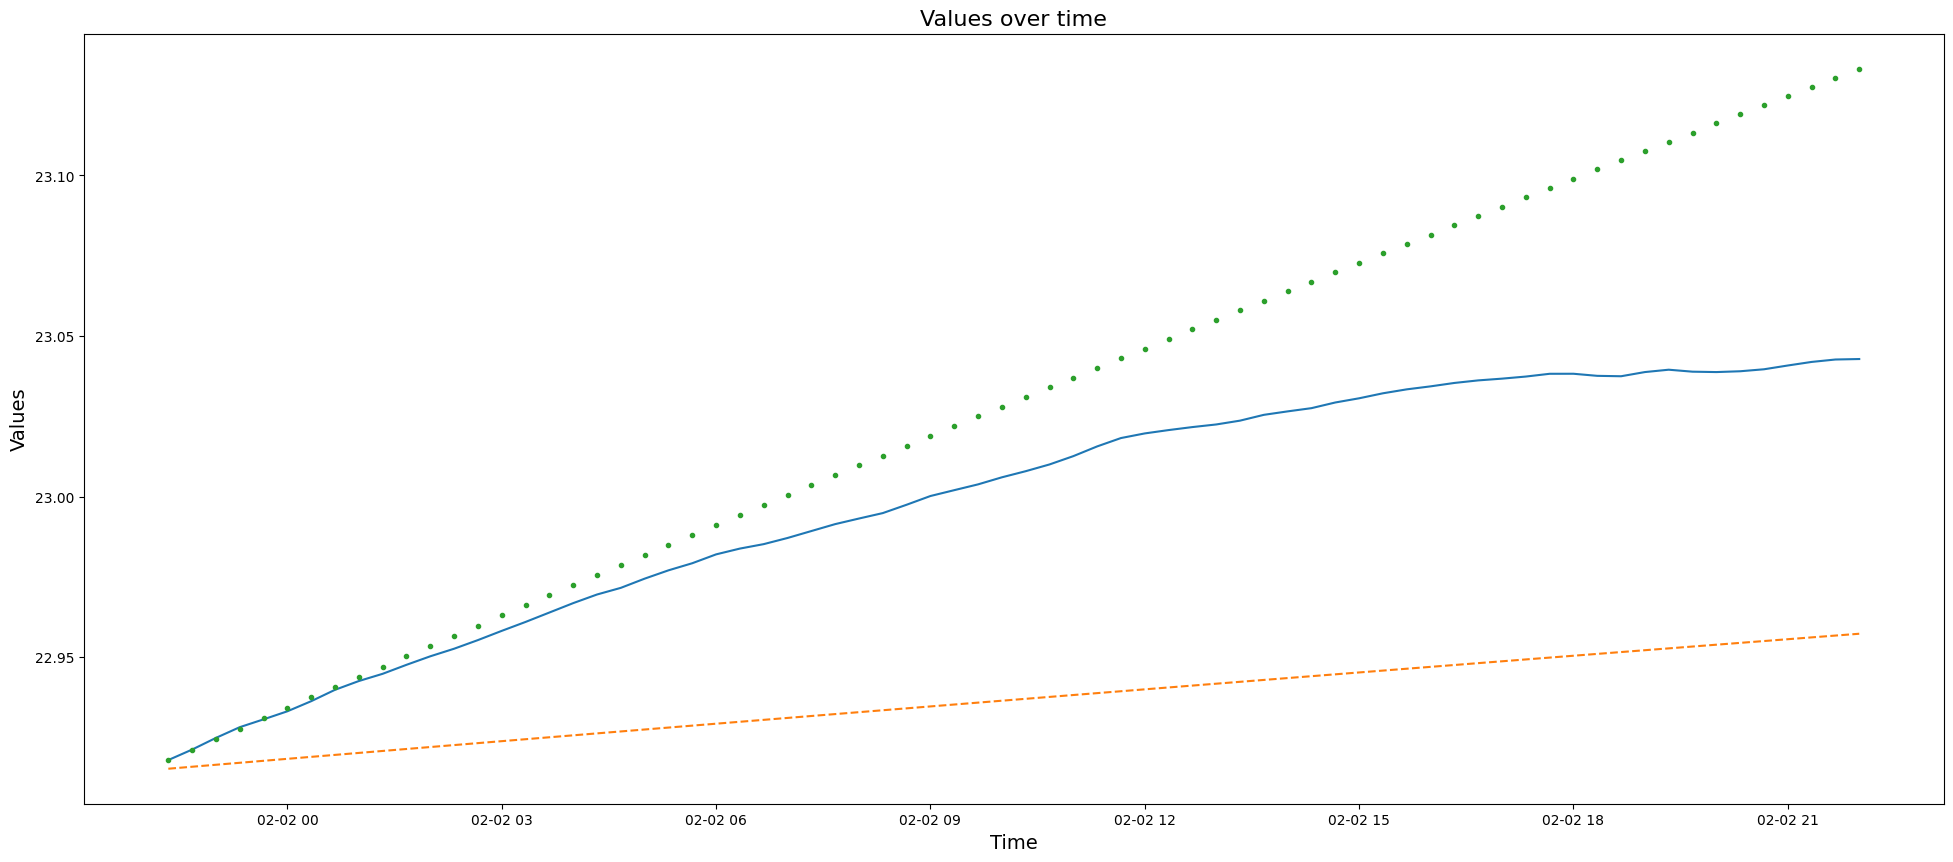

In [20]:
#define size
plt.figure(figsize=(24,10))
#add axes labels and a title
plt.ylabel('Values', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Values over time', fontsize=16)
plt.plot(test_data, "-", label = 'tests')
plt.plot(predictions1,"--", label = 'pred1')
plt.plot(predictions12,".", label = 'pred12')

In [24]:
#training LET INCREASE THE LAG
model = AutoReg(train_data, lags = 3)
AR3fit = model.fit()
predictions3 = AR3fit.predict(start=start, end=end)


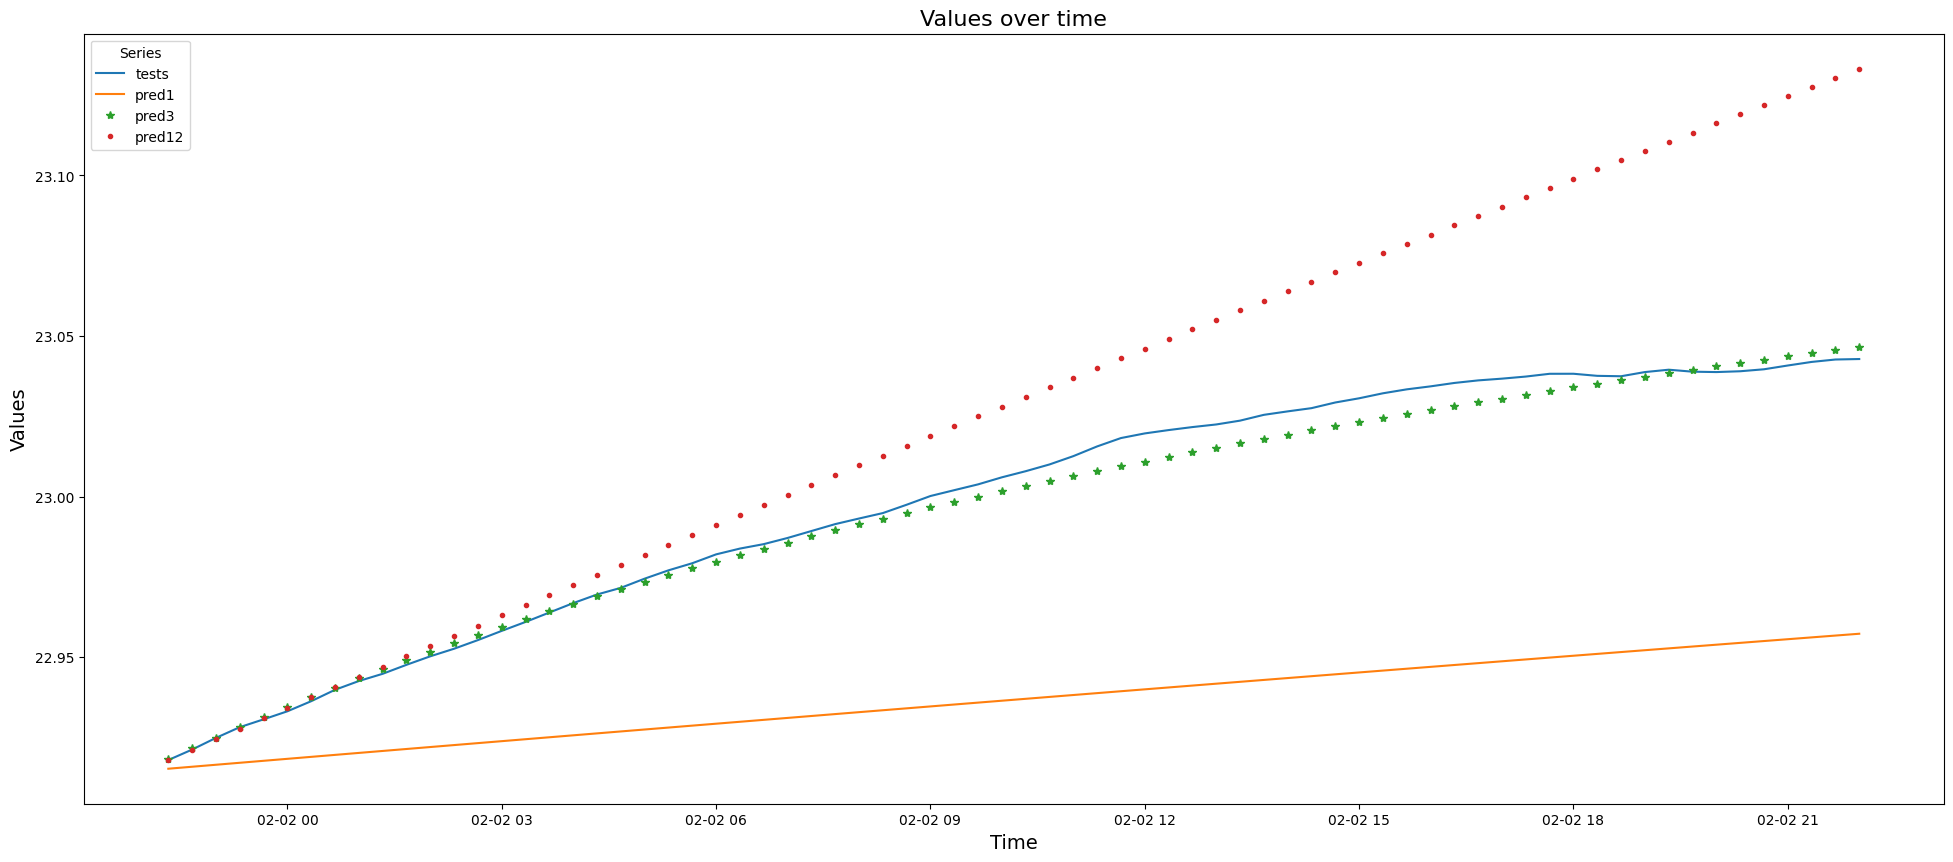

In [25]:
#define size
plt.figure(figsize=(24,10))
#add axes labels and a title
plt.ylabel('Values', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Values over time', fontsize=16)
plt.plot(test_data, "-", label = 'tests')
plt.plot(predictions1,"-", label = 'pred1')
plt.plot(predictions3,"*", label = 'pred3')
plt.plot(predictions12,".", label = 'pred12')
#add legend
plt.legend(title='Series')


In [26]:
#Evaluate the model
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(3)','AR(12)']
preds = [predictions1, predictions3, predictions12]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test_data, preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 0.004493769789
AR(3) Error: 1.92484857e-05
AR(12) Error: 0.001623840969


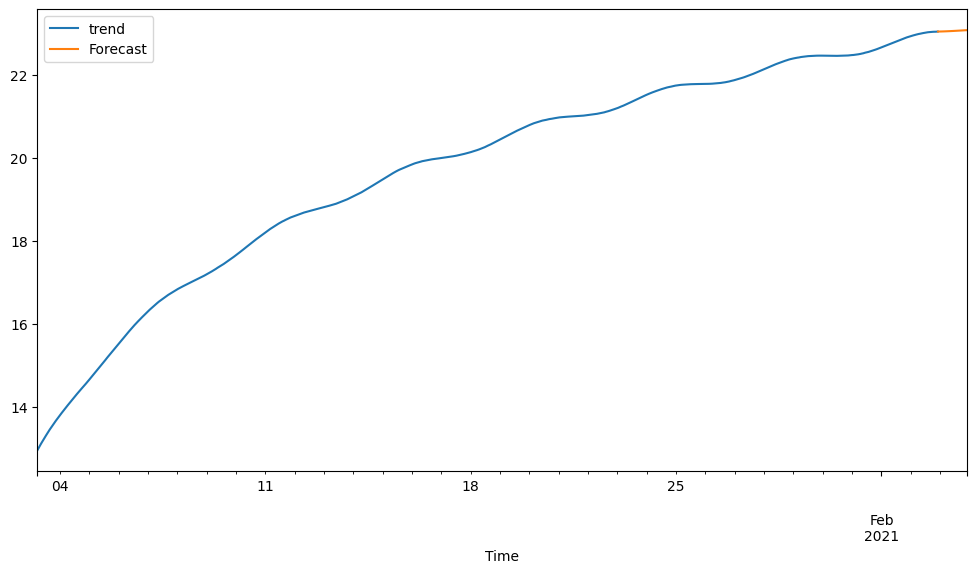

In [27]:
#Forecasting
# First, retrain the model on the full dataset
model = AutoReg(data, lags = 3)

# Next, fit the model
ARfit = model.fit()

# Make predictions
fcast = ARfit.predict(start=len(data), end=len(data)+72, dynamic=False).rename('Forecast')

# Plot the results
data.plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));